In [84]:
import pandas as pd
data = pd.read_csv('n11611553_CombinedTrainingData.csv')
data.head()

,meanX,sdX,rangeX,meanY,sdY,rangeY,meanZ,sdZ,rangeZ,meanGx,sdGx,rangeGx,meanGy,sdGy,rangeGy,meanGz,sdGz,rangeGz,label,studentId
0,0.8922,0.2107,0.8303,0.0381,0.0290,0.1162,-0.0347,0.1504,0.6028,-17.6717,23.2170,62.1338,-204.5369,232.9069,626.4648,4.6834,5.3712,15.0757,Right,11611553
1,0.9239,0.1547,0.6499,0.0589,0.0322,0.1082,0.0484,0.1363,0.6276,-9.0251,16.6460,49.0112,-178.4058,217.4450,614.9902,1.1719,2.6221,8.5449,Right,11611553
2,0.9301,0.1498,0.6594,0.0470,0.0317,0.1195,-0.0177,0.1142,0.4865,-10.3280,13.4871,38.8184,-163.7486,217.7073,632.0190,2.1232,2.5445,7.2632,Right,11611553
3,0.9190,0.1970,0.8376,0.0662,0.0368,0.1199,0.0313,0.1533,0.6186,-18.3390,22.2053,68.2373,-192.4316,253.4296,700.5005,1.1149,1.9271,6.4087,Right,11611553
4,0.9271,0.1419,0.6176,0.0133,0.0191,0.0684,-0.0693,0.0973,0.4619,-9.7087,18.8354,55.2368,-176.8758,231.4860,690.2466,1.6683,4.5471,15.6250,Right,11611553


# SVM Framework for Motion Data Classification

This notebook provides a framework for classifying motion data using Support Vector Machines (SVM). 
The data contains accelerometer features (mean, standard deviation, range) for X, Y, Z axes along with wrist position and activity labels.

In [85]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random state for reproducibility
RANDOM_STATE = 42

## Step 1: Data Exploration and Understanding

In [86]:
# Load and explore the data
data = pd.read_csv('n11611553_CombinedTrainingData.csv')

print("Dataset Shape:", data.shape)
print("\nColumn Names:")
print(data.columns.tolist())
print("\nData Types:")
print(data.dtypes)
print("\nFirst few rows:")
print(data.head())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Check class distribution
print("\nClass Distribution:")
print(data['label'].value_counts())

# Basic statistics
print("\nBasic Statistics:")
print(data.describe())

Dataset Shape: (108, 20)

Column Names:
['meanX', 'sdX', 'rangeX', 'meanY', 'sdY', 'rangeY', 'meanZ', 'sdZ', 'rangeZ', 'meanGx', 'sdGx', 'rangeGx', 'meanGy', 'sdGy', 'rangeGy', 'meanGz', 'sdGz', 'rangeGz', 'label', 'studentId']

Data Types:
meanX        float64
sdX          float64
rangeX       float64
meanY        float64
sdY          float64
rangeY       float64
meanZ        float64
sdZ          float64
rangeZ       float64
meanGx       float64
sdGx         float64
rangeGx      float64
meanGy       float64
sdGy         float64
rangeGy      float64
meanGz       float64
sdGz         float64
rangeGz      float64
label         object
studentId      int64
dtype: object

First few rows:
    meanX     sdX  rangeX   meanY     sdY  rangeY   meanZ     sdZ  rangeZ  \
0  0.8922  0.2107  0.8303  0.0381  0.0290  0.1162 -0.0347  0.1504  0.6028   
1  0.9239  0.1547  0.6499  0.0589  0.0322  0.1082  0.0484  0.1363  0.6276   
2  0.9301  0.1498  0.6594  0.0470  0.0317  0.1195 -0.0177  0.1142  0.4865   


## Step 2: Data Visualization

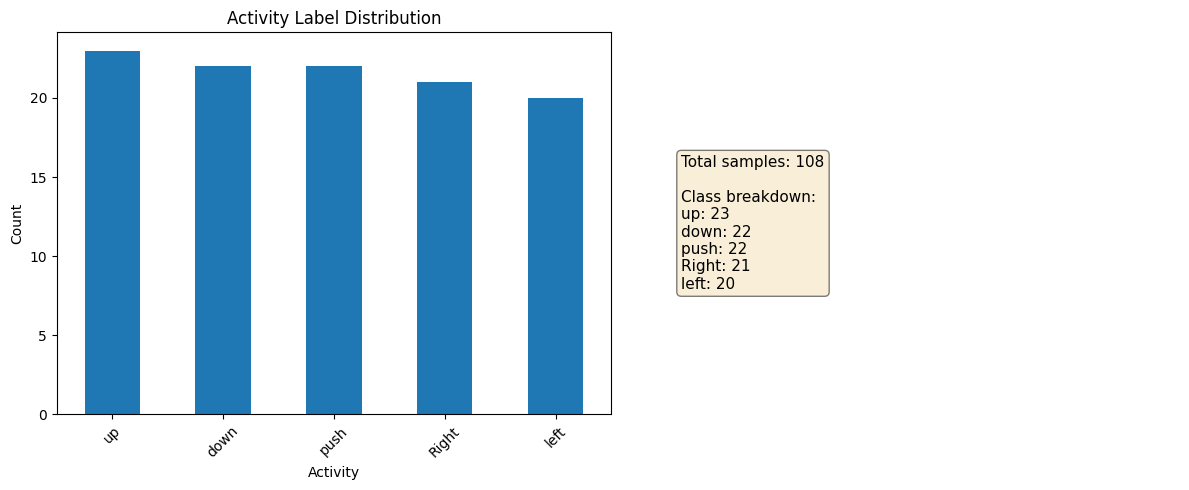

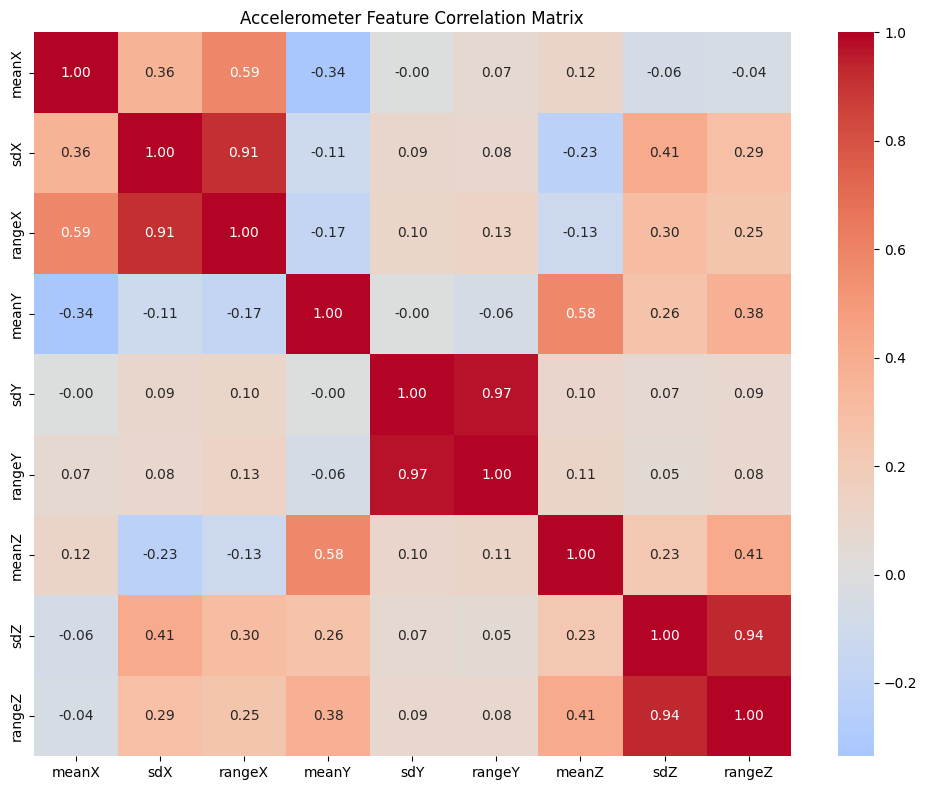

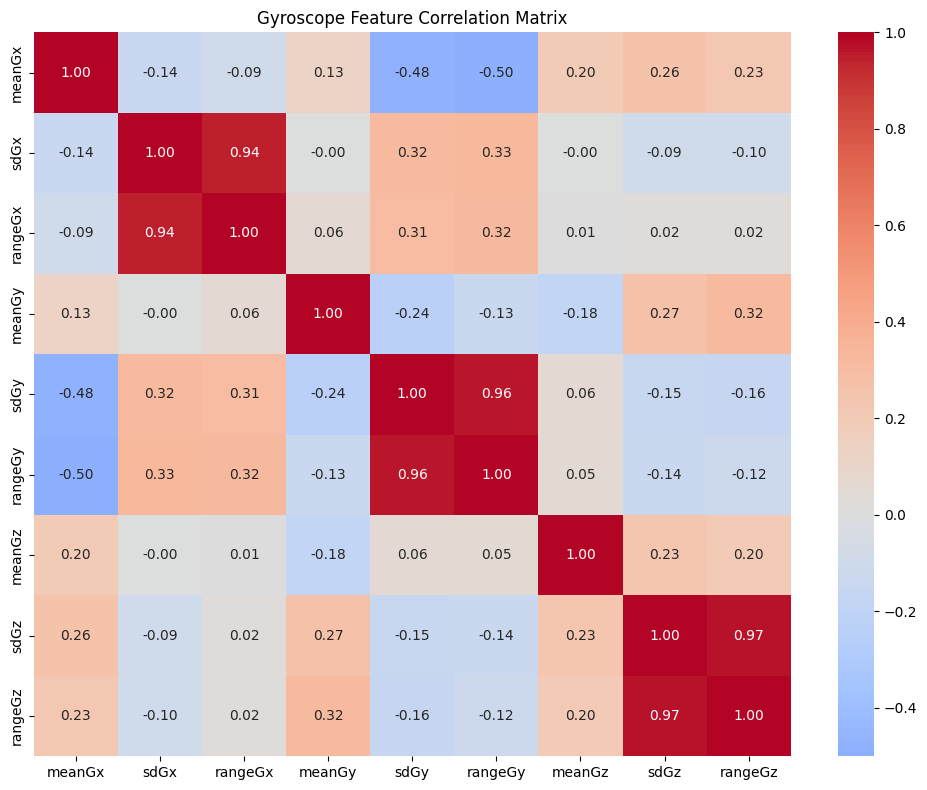

In [87]:
# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
data['label'].value_counts().plot(kind='bar')
plt.title('Activity Label Distribution')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
# Show the number of samples per class
label_counts = data['label'].value_counts()
plt.text(0.1, 0.5, f"Total samples: {len(data)}\n\nClass breakdown:\n" + 
         "\n".join([f"{label}: {count}" for label, count in label_counts.items()]),
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.axis('off')

plt.tight_layout()
plt.show()

# Correlation matrix of numerical features (accelerometer only)
accel_features = ['meanX', 'sdX', 'rangeX', 'meanY', 'sdY', 'rangeY', 'meanZ', 'sdZ', 'rangeZ']
plt.figure(figsize=(10, 8))
correlation_matrix = data[accel_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Accelerometer Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Correlation matrix for gyroscope features
gyro_features = ['meanGx', 'sdGx', 'rangeGx', 'meanGy', 'sdGy', 'rangeGy', 'meanGz', 'sdGz', 'rangeGz']
plt.figure(figsize=(10, 8))
correlation_matrix_gyro = data[gyro_features].corr()
sns.heatmap(correlation_matrix_gyro, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Gyroscope Feature Correlation Matrix')
plt.tight_layout()
plt.show()


## Step 3: Data Preprocessing

In [88]:
# Define features and target
# The CSV contains accelerometer (X,Y,Z) and gyroscope (Gx,Gy,Gz) statistics
# Features: mean, standard deviation (sd), and range for each axis
feature_columns = ['meanX', 'sdX', 'rangeX', 'meanY', 'sdY', 'rangeY', 
                   'meanZ', 'sdZ', 'rangeZ', 'meanGx', 'sdGx', 'rangeGx',
                   'meanGy', 'sdGy', 'rangeGy', 'meanGz', 'sdGz', 'rangeGz']
X = data[feature_columns]
y = data['label']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
print("\nFeatures being used:")
for i, feature in enumerate(feature_columns):
    print(f"{i+1}. {feature}")

# Encode categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nLabel encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Feature scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed.")


Feature matrix shape: (108, 18)
Target vector shape: (108,)

Features being used:
1. meanX
2. sdX
3. rangeX
4. meanY
5. sdY
6. rangeY
7. meanZ
8. sdZ
9. rangeZ
10. meanGx
11. sdGx
12. rangeGx
13. meanGy
14. sdGy
15. rangeGy
16. meanGz
17. sdGz
18. rangeGz

Label encoding mapping:
Right -> 0
down -> 1
left -> 2
push -> 3
up -> 4

Training set size: 86
Test set size: 22

Feature scaling completed.


## Step 4: SVM Model Training and Hyperparameter Tuning

In [89]:
# Basic SVM model
print("Training basic SVM model...")
svm_basic = SVC(random_state=RANDOM_STATE)
svm_basic.fit(X_train_scaled, y_train)

# Cross-validation score for basic model
cv_scores_basic = cross_val_score(svm_basic, X_train_scaled, y_train, cv=5)
print(f"Basic SVM Cross-validation accuracy: {cv_scores_basic.mean():.4f} (+/- {cv_scores_basic.std() * 2:.4f})")

# Hyperparameter tuning with GridSearchCV
# Note: Adding probability=True for better confidence estimates
print("\nPerforming hyperparameter tuning...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Use a smaller grid for faster execution if needed
# param_grid = {
#     'C': [0.1, 1, 10],
#     'gamma': ['scale', 0.01, 0.1],
#     'kernel': ['rbf', 'linear']
# }

grid_search = GridSearchCV(
    SVC(random_state=RANDOM_STATE, probability=True),  # Enable probability estimation
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_svm = grid_search.best_estimator_
print(f"Best model has probability estimation: {hasattr(best_svm, 'probability') and best_svm.probability}")

Training basic SVM model...
Basic SVM Cross-validation accuracy: 0.8137 (+/- 0.2287)

Performing hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.8719
Best model has probability estimation: True

Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.8719
Best model has probability estimation: True


## Step 5: Model Evaluation

Test Accuracy: 0.8636

Classification Report:
              precision    recall  f1-score   support

       Right       1.00      0.75      0.86         4
        down       1.00      0.60      0.75         5
        left       0.80      1.00      0.89         4
        push       0.80      1.00      0.89         4
          up       0.83      1.00      0.91         5

    accuracy                           0.86        22
   macro avg       0.89      0.87      0.86        22
weighted avg       0.89      0.86      0.86        22



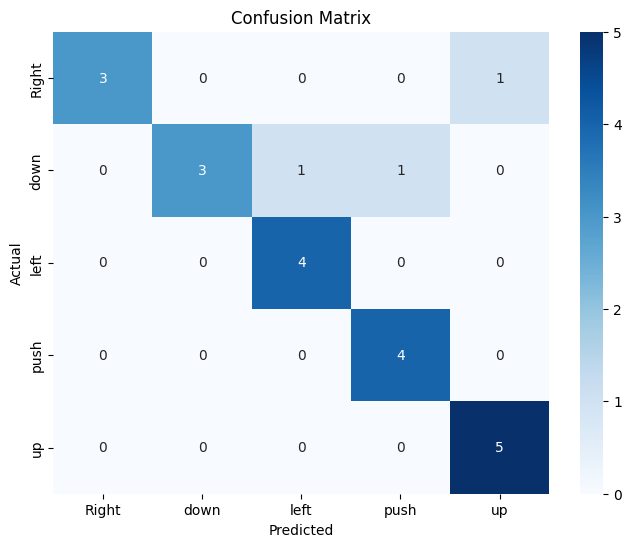


Feature importance visualization not available for rbf kernel.


In [90]:
# Make predictions
y_pred = best_svm.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance (for linear kernel only)
if best_svm.kernel == 'linear':
    feature_importance = np.abs(best_svm.coef_[0])
    feature_names = feature_columns
    
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importance)[::-1]
    plt.bar(range(len(feature_importance)), feature_importance[indices])
    plt.xticks(range(len(feature_importance)), [feature_names[i] for i in indices], rotation=45)
    plt.title('Feature Importance (Linear SVM)')
    plt.ylabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.show()
else:
    print(f"\nFeature importance visualization not available for {best_svm.kernel} kernel.")

## Step 6: Advanced Analysis (Optional)

Comparing different SVM kernels:
LINEAR Kernel:
  CV Accuracy: 0.7686 (+/- 0.1879)
  Test Accuracy: 0.8636

RBF Kernel:
  CV Accuracy: 0.8137 (+/- 0.2287)
  Test Accuracy: 0.9545

POLY Kernel:
  CV Accuracy: 0.6176 (+/- 0.1745)
  Test Accuracy: 0.8182

SIGMOID Kernel:
  CV Accuracy: 0.8373 (+/- 0.1557)
  Test Accuracy: 0.8182



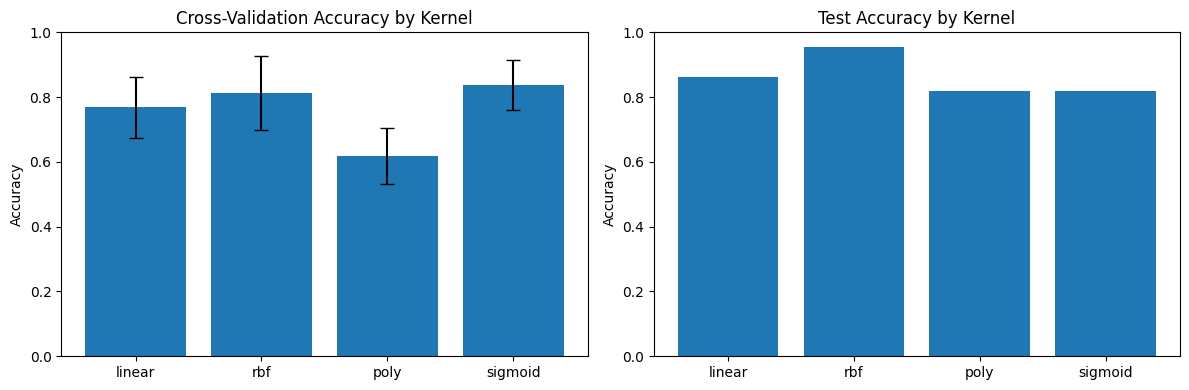

In [91]:
# Compare different SVM kernels
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_results = {}

print("Comparing different SVM kernels:")
for kernel in kernels:
    svm_kernel = SVC(kernel=kernel, random_state=RANDOM_STATE)
    svm_kernel.fit(X_train_scaled, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(svm_kernel, X_train_scaled, y_train, cv=5)
    
    # Test accuracy
    y_pred_kernel = svm_kernel.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred_kernel)
    
    kernel_results[kernel] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy
    }
    
    print(f"{kernel.upper()} Kernel:")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print()

# Visualize kernel comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
cv_means = [kernel_results[k]['cv_mean'] for k in kernels]
cv_stds = [kernel_results[k]['cv_std'] for k in kernels]
plt.bar(kernels, cv_means, yerr=cv_stds, capsize=5)
plt.title('Cross-Validation Accuracy by Kernel')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
test_accs = [kernel_results[k]['test_accuracy'] for k in kernels]
plt.bar(kernels, test_accs)
plt.title('Test Accuracy by Kernel')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## Step 7: Model Deployment and Prediction Function

In [92]:
# Create a prediction function for new data
def predict_activity(meanX, sdX, rangeX, meanY, sdY, rangeY, meanZ, sdZ, rangeZ,
                     meanGx, sdGx, rangeGx, meanGy, sdGy, rangeGy, meanGz, sdGz, rangeGz):
    """
    Predict activity based on motion sensor features
    
    Parameters:
    - meanX, sdX, rangeX: X-axis accelerometer statistics
    - meanY, sdY, rangeY: Y-axis accelerometer statistics  
    - meanZ, sdZ, rangeZ: Z-axis accelerometer statistics
    - meanGx, sdGx, rangeGx: X-axis gyroscope statistics
    - meanGy, sdGy, rangeGy: Y-axis gyroscope statistics
    - meanGz, sdGz, rangeGz: Z-axis gyroscope statistics
    
    Returns:
    - Predicted activity label
    - Prediction confidence score
    """
    import pandas as pd
    feature_columns = ['meanX', 'sdX', 'rangeX', 'meanY', 'sdY', 'rangeY', 
                       'meanZ', 'sdZ', 'rangeZ', 'meanGx', 'sdGx', 'rangeGx',
                       'meanGy', 'sdGy', 'rangeGy', 'meanGz', 'sdGz', 'rangeGz']
    
    features_dict = {
        'meanX': [meanX], 'sdX': [sdX], 'rangeX': [rangeX],
        'meanY': [meanY], 'sdY': [sdY], 'rangeY': [rangeY],
        'meanZ': [meanZ], 'sdZ': [sdZ], 'rangeZ': [rangeZ],
        'meanGx': [meanGx], 'sdGx': [sdGx], 'rangeGx': [rangeGx],
        'meanGy': [meanGy], 'sdGy': [sdGy], 'rangeGy': [rangeGy],
        'meanGz': [meanGz], 'sdGz': [sdGz], 'rangeGz': [rangeGz]
    }
    
    features_df = pd.DataFrame(features_dict)
    
    # Scale the features
    features_scaled = scaler.transform(features_df)
    
    # Make prediction
    prediction_encoded = best_svm.predict(features_scaled)[0]
    
    # Get confidence score
    if hasattr(best_svm, 'predict_proba') and hasattr(best_svm, 'probability') and best_svm.probability:
        prediction_proba = best_svm.predict_proba(features_scaled)[0]
        confidence = np.max(prediction_proba)
    else:
        # For SVM without probability=True, use decision function
        decision_scores = best_svm.decision_function(features_scaled)[0]
        if len(label_encoder.classes_) == 2:
            confidence = abs(decision_scores)
        else:
            confidence = np.max(decision_scores) if isinstance(decision_scores, np.ndarray) else abs(decision_scores)
    
    # Decode the prediction
    prediction_label = label_encoder.inverse_transform([int(prediction_encoded)])[0]
    
    return prediction_label, confidence

# Example prediction
print("Example prediction:")
sample_features = X_test.iloc[0]  # Use first test sample
predicted_label, confidence = predict_activity(*sample_features)
actual_label = label_encoder.inverse_transform([y_test[0]])[0]

print(f"Input features: {sample_features.to_dict()}")
print(f"Predicted activity: {predicted_label}")
print(f"Actual activity: {actual_label}")
print(f"Confidence score: {confidence:.4f}")

# Save the model (optional)
import joblib

# Save the trained model, scaler, and label encoder
joblib.dump(best_svm, 'svm_motion_classifier.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("\nModel, scaler, and label encoder saved to disk.")


Example prediction:
Input features: {'meanX': 0.8274, 'sdX': 0.1661, 'rangeX': 0.6472, 'meanY': 0.0572, 'sdY': 0.0409, 'rangeY': 0.1191, 'meanZ': -0.3396, 'sdZ': 0.1257, 'rangeZ': 0.5251, 'meanGx': -9.9487, 'sdGx': 8.2091, 'rangeGx': 29.7241, 'meanGy': -168.6849, 'sdGy': 164.9925, 'rangeGy': 469.7876, 'meanGz': 6.3314, 'sdGz': 8.845, 'rangeGz': 28.5034}
Predicted activity: up
Actual activity: up
Confidence score: 0.4569

Model, scaler, and label encoder saved to disk.


## Step 8: Sharing the Trained Model

There are several ways to get your trained model to the Raspberry Pi without retraining:

In [93]:
# Method 1: Include model files in Git repository
print("Current model files:")
import os
model_files = ['svm_motion_classifier.pkl', 'feature_scaler.pkl', 'label_encoder.pkl']
for file in model_files:
    if os.path.exists(file):
        size = os.path.getsize(file) / 1024  # Size in KB
        print(f"✅ {file}: {size:.1f} KB")
    else:
        print(f"❌ {file}: Not found")

# Method 2: Create a simple model loader for the Pi
def load_trained_model():
    """
    Load the pre-trained SVM model, scaler, and label encoder
    Use this function on the Raspberry Pi to load the model
    """
    import joblib
    import numpy as np
    
    try:
        # Load the trained components
        model = joblib.load('svm_motion_classifier.pkl')
        scaler = joblib.load('feature_scaler.pkl') 
        encoder = joblib.load('label_encoder.pkl')
        
        print("✅ Pre-trained model loaded successfully!")
        print(f"📊 Model type: {type(model).__name__}")
        print(f"🏷️  Available labels: {list(encoder.classes_)}")
        
        return model, scaler, encoder
    except FileNotFoundError as e:
        print(f"❌ Model file not found: {e}")
        print("💡 Make sure you've trained and saved the model first")
        return None, None, None

def predict_with_loaded_model(model, scaler, encoder, features):
    """
    Helper function to make predictions with proper data type handling
    This version fixes the feature names warning
    """
    import pandas as pd
    import numpy as np
    
    # Define feature column names (must match training data)
    feature_columns = ['meanX', 'sdX', 'rangeX', 'meanY', 'sdY', 'rangeY', 
                       'meanZ', 'sdZ', 'rangeZ', 'meanGx', 'sdGx', 'rangeGx',
                       'meanGy', 'sdGy', 'rangeGy', 'meanGz', 'sdGz', 'rangeGz']
    
    # Convert features to DataFrame with proper column names
    if isinstance(features, (list, tuple, np.ndarray)):
        if len(features) != len(feature_columns):
            raise ValueError(f"Expected {len(feature_columns)} features, got {len(features)}")
        
        # Create DataFrame with proper column names
        features_dict = {col: [val] for col, val in zip(feature_columns, features)}
        features_df = pd.DataFrame(features_dict)
    elif isinstance(features, dict):
        # If already a dict, convert to DataFrame
        features_df = pd.DataFrame([features])
    else:
        # Assume it's already a DataFrame
        features_df = features.copy()
    
    # Ensure we have the right columns in the right order
    features_df = features_df[feature_columns]
    
    # Scale features (this will now have proper feature names)
    features_scaled = scaler.transform(features_df)
    
    # Make prediction
    prediction_encoded = model.predict(features_scaled)[0]
    
    # Get confidence score
    if hasattr(model, 'predict_proba') and hasattr(model, 'probability') and model.probability:
        probabilities = model.predict_proba(features_scaled)[0]
        confidence = np.max(probabilities)
    else:
        # Use decision function for confidence
        decision_scores = model.decision_function(features_scaled)[0]
        if len(encoder.classes_) == 2:
            confidence = abs(decision_scores)
        else:
            confidence = np.max(decision_scores) if isinstance(decision_scores, np.ndarray) else abs(decision_scores)
    
    # Decode prediction
    prediction_label = encoder.inverse_transform([int(prediction_encoded)])[0]
    
    return prediction_label, confidence

# Create a simple prediction function for use on Raspberry Pi
def pi_predict_activity(meanX, sdX, rangeX, meanY, sdY, rangeY, meanZ, sdZ, rangeZ,
                        meanGx, sdGx, rangeGx, meanGy, sdGy, rangeGy, meanGz, sdGz, rangeGz,
                        model=None, scaler=None, encoder=None):
    """
    Optimized prediction function for Raspberry Pi use
    Pass the loaded model, scaler, and encoder to avoid reloading
    """
    if model is None or scaler is None or encoder is None:
        model, scaler, encoder = load_trained_model()
        if model is None:
            return None, 0.0
    
    features = [meanX, sdX, rangeX, meanY, sdY, rangeY, meanZ, sdZ, rangeZ,
                meanGx, sdGx, rangeGx, meanGy, sdGy, rangeGy, meanGz, sdGz, rangeGz]
    return predict_with_loaded_model(model, scaler, encoder, features)

# Test the loader
print("\n🧪 Testing model loader:")
loaded_model, loaded_scaler, loaded_encoder = load_trained_model()

if loaded_model is not None:
    # Test prediction with the same sample using proper data handling
    sample_features = X_test.iloc[0].values  # Convert to numpy array
    prediction_label, confidence = predict_with_loaded_model(loaded_model, loaded_scaler, loaded_encoder, sample_features)
    actual_label = label_encoder.inverse_transform([y_test[0]])[0]
    print(f"✅ Test prediction: {prediction_label}")
    print(f"🎯 Actual label: {actual_label}")
    print(f"📊 Confidence: {confidence:.4f}")
    print(f"✅ Match: {'Yes' if prediction_label == actual_label else 'No'}")


Current model files:
✅ svm_motion_classifier.pkl: 14.2 KB
✅ feature_scaler.pkl: 1.4 KB
✅ label_encoder.pkl: 0.5 KB

🧪 Testing model loader:
✅ Pre-trained model loaded successfully!
📊 Model type: SVC
🏷️  Available labels: ['Right', 'down', 'left', 'push', 'up']
✅ Test prediction: up
🎯 Actual label: up
📊 Confidence: 0.4569
✅ Match: Yes
